In [4]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import sklearn as sk
import matplotlib as mpl

In [5]:
mpl.rc('font', family='NanumGothic')
mpl.rc('axes', unicode_minus=False)

In [20]:
import warnings
warnings.filterwarnings('ignore')

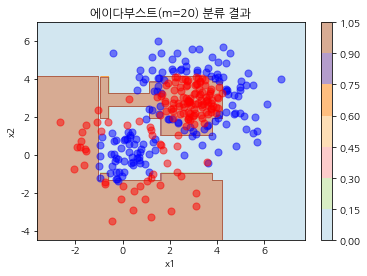

In [6]:
from sklearn.datasets import make_gaussian_quantiles
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=100, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=200, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))

class MyAdaBoostClassifier(AdaBoostClassifier):
    
    def __init__(self,
                 base_estimator=None,
                 n_estimators=50,
                 learning_rate=1.,
                 algorithm='SAMME.R',
                 random_state=None):

        super(MyAdaBoostClassifier, self).__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=random_state)
        self.sample_weight = [None] * n_estimators
        
    def _boost(self, iboost, X, y, sample_weight, random_state):
        sample_weight, estimator_weight, estimator_error = \
        super(MyAdaBoostClassifier, self)._boost(iboost, X, y, sample_weight, random_state)
        self.sample_weight[iboost] = sample_weight.copy()
        return sample_weight, estimator_weight, estimator_error
    
model_ada = MyAdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=0), n_estimators=20)
model_ada.fit(X, y)

def plot_result(model, title="분류결과", legend=False, s=50):
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02), np.arange(x2_min, x2_max, 0.02))
    if isinstance(model, list):
        Y = model[0].predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)
        for i in range(len(model) - 1):
            Y += model[i + 1].predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)
    else:
        Y = model.predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)
    cs = plt.contourf(xx1, xx2, Y, cmap=plt.cm.Paired, alpha=0.5)
    for i, n, c in zip(range(2), "01", "br"):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=c, s=s, alpha=0.5, label="Class %s" % n)
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.colorbar(cs)
    if legend:
        plt.legend()
    plt.grid(False)

plot_result(model_ada, "에이다부스트(m=20) 분류 결과")

## 그레디언트 부스트

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

model_grad = GradientBoostingClassifier(n_estimators=100, max_depth=2, random_state=0)

In [11]:
%%time
model_grad.fit(X, y)

Wall time: 83.9 ms


GradientBoostingClassifier(max_depth=2, random_state=0)

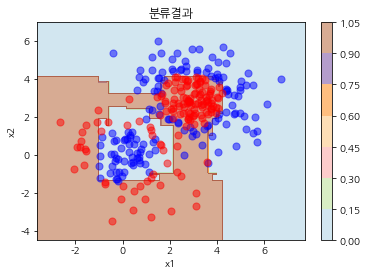

In [12]:
plot_result(model_grad)

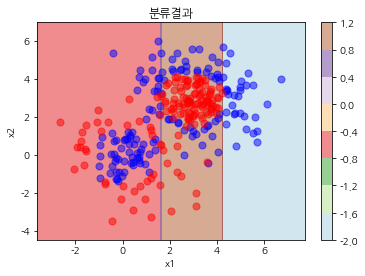

In [13]:
plot_result(model_grad.estimators_[0][0])

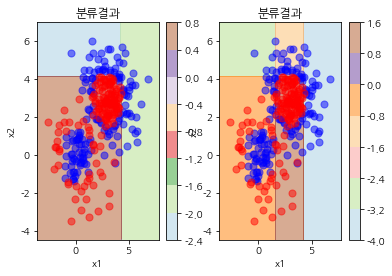

In [14]:
plt.subplot(121)
plot_result(model_grad.estimators_[1][0])
plt.subplot(122)
plot_result([model_grad.estimators_[0][0], model_grad.estimators_[1][0]])

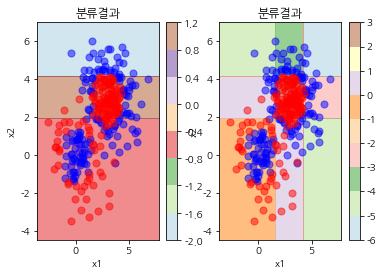

In [15]:
plt.subplot(121)
plot_result(model_grad.estimators_[2][0])
plt.subplot(122)
plot_result([model_grad.estimators_[0][0], 
             model_grad.estimators_[1][0],
             model_grad.estimators_[2][0]])

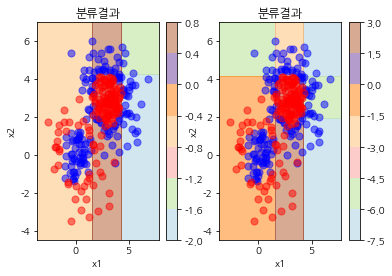

In [16]:
plt.subplot(121)
plot_result(model_grad.estimators_[3][0])
plt.subplot(122)
plot_result([model_grad.estimators_[0][0], 
             model_grad.estimators_[1][0],
             model_grad.estimators_[2][0],
             model_grad.estimators_[3][0]])

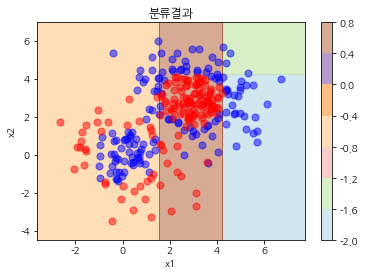

In [17]:
plot_result(model_grad.estimators_[3][0])

## XGBoost 라이브러리

In [18]:
import xgboost

model_xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=1, radom_state=0)

In [21]:
%%time
model_xgb.fit(X, y)

[21:01:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "radom_state" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:01:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 57.2 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=1, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', radom_state=0,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

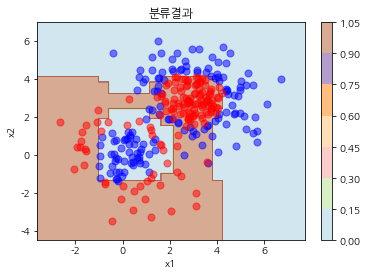

In [22]:
plot_result(model_xgb)

## LightGBM 라이브러리

In [23]:
import lightgbm

model_lgbm = lightgbm.LGBMClassifier(n_estimators=100, max_depth=1, random_state=0)

In [24]:
%time
model_lgbm.fit(X, y)

Wall time: 0 ns


LGBMClassifier(max_depth=1, random_state=0)

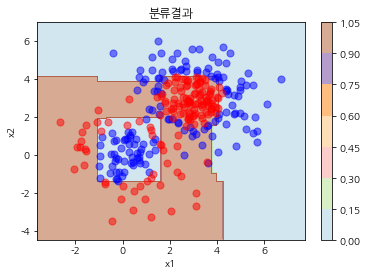

In [25]:
plot_result(model_lgbm)

In [ ]:
# 